In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [5]:
df = pd.read_csv("tree_species_dataset.csv")
print(df.head())
print("\nDataset shape:", df.shape)

   Species  Leaf_Length  Leaf_Width Leaf_Shape Leaf_Margin Bark_Texture  \
0      Oak         12.5         7.8       Oval    Serrated     Furrowed   
1    Maple         10.2        12.3    Palmate       Lobed       Smooth   
2     Pine          8.0         0.2     Needle      Smooth       Scales   
3    Birch          7.5         5.5       Oval    Serrated      Peeling   
4  Redwood          5.0         0.3     Needle      Smooth      Fibrous   

  Flower_Color  Height  Latitude  Longitude  
0        Brown      25      45.5     -122.6  
1        Green      20      47.6     -122.3  
2       Yellow      30      44.0     -123.1  
3        White      15      46.2     -121.8  
4        Brown     100      41.8     -124.1  

Dataset shape: (6, 10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Species       6 non-null      object 
 1   Leaf_Length   6 non-null      float64
 2   Leaf_Width    6 non-null      float64
 3   Leaf_Shape    6 non-null      object 
 4   Leaf_Margin   6 non-null      object 
 5   Bark_Texture  6 non-null      object 
 6   Flower_Color  6 non-null      object 
 7   Height        6 non-null      int64  
 8   Latitude      6 non-null      float64
 9   Longitude     6 non-null      float64
dtypes: float64(4), int64(1), object(5)
memory usage: 608.0+ bytes
None

Missing values per column:
Species         0
Leaf_Length     0
Leaf_Width      0
Leaf_Shape      0
Leaf_Margin     0
Bark_Texture    0
Flower_Color    0
Height          0
Latitude        0
Longitude       0
dtype: int64


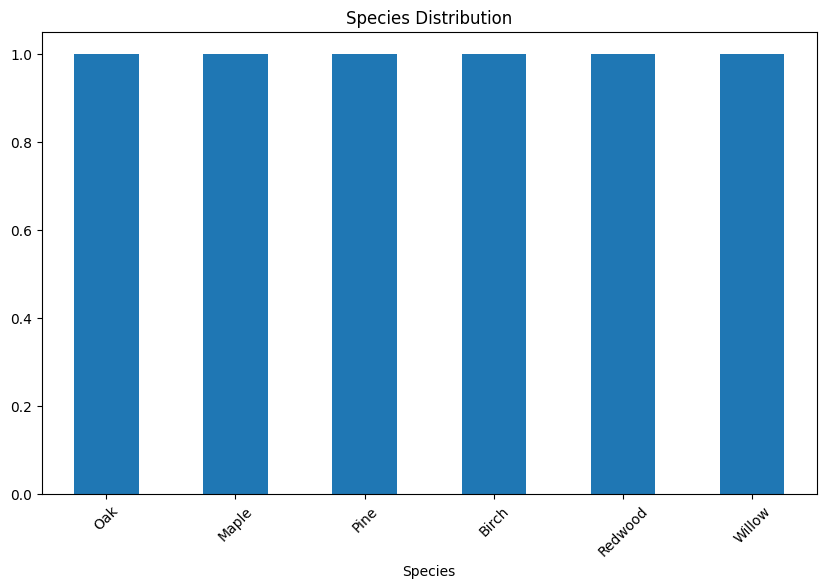

In [6]:
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

plt.figure(figsize=(10,6))
df['Species'].value_counts().plot(kind='bar')
plt.title('Species Distribution')
plt.xticks(rotation=45)
plt.show()

In [7]:
df.fillna(df.mode().iloc[0], inplace=True)

categorical_cols = ['Leaf_Shape', 'Leaf_Margin', 'Bark_Texture', 'Flower_Color']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
species_encoder = LabelEncoder()
df['Species_Encoded'] = species_encoder.fit_transform(df['Species'])

features = ['Leaf_Length', 'Leaf_Width', 'Leaf_Shape', 'Leaf_Margin', 
            'Bark_Texture', 'Flower_Color', 'Height', 'Latitude', 'Longitude']
X = df[features]
y = df['Species_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import pandas as pd

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

min_samples = pd.Series(y_train).value_counts().min()
cv_folds = min(3, min_samples)

if cv_folds > 1:
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                    n_iter=10, cv=cv, random_state=42,
                                    n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    best_rf = random_search.best_estimator_
    print("Best parameters:", random_search.best_params_)
else:
    print("Warning: Not enough samples for cross-validation")
    print("Using default parameters instead")
    best_rf = rf.fit(X_train, y_train)

Class distribution in training set:
Species_Encoded
5    1
3    1
4    1
0    1
Name: count, dtype: int64
Using default parameters instead


In [10]:
cv = min(3, y_train.value_counts().min())  # Use smaller number

In [11]:
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=species_encoder.classes_))

feature_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [14]:
joblib.dump(best_rf, 'tree_species_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(species_encoder, 'species_encoder.pkl')

def predict_species(features):
    model = joblib.load('tree_species_model.pkl')
    encoders = joblib.load('label_encoders.pkl')
    

    for col in categorical_cols:
        features[col] = encoders[col].transform([features[col]])[0]
    
 
    input_df = pd.DataFrame([features])
    
  
    pred = model.predict(input_df)
    species = species_encoder.inverse_transform(pred)
    
    return species[0]

In [15]:

sample_tree = {
    'Leaf_Length': 12.5,
    'Leaf_Width': 7.8,
    'Leaf_Shape': 'Oval',
    'Leaf_Margin': 'Serrated',
    'Bark_Texture': 'Furrowed',
    'Flower_Color': 'White',
    'Height': 25,
    'Latitude': 45.5,
    'Longitude': -122.6
}


print("Predicted species:", predict_species(sample_tree))

Predicted species: Birch
